In [54]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate

##### Error Bars
 - aplha = errs_train**2 in gpr sklearn
 - Do the errors represent standard deviation???, why square them???
 - look at noise and white kernel
 - research a lot

##### Hyper parameter posterios

##### Kernel Justification

### Questions
how many l hyper-parameters. I was maybe over-fitting

In [58]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

,x,y,z,w,data,error
0,0.1,-1.439897,0.0,0.25,-2.831628,0.561478
1,0.1,-1.308997,0.5,0.25,-3.006489,0.485720
2,0.1,-1.178097,1.0,0.25,-2.354835,1.270193
3,0.1,-1.047198,1.0,0.25,-2.974002,0.983807
4,0.1,-0.916298,1.0,0.25,-2.401510,1.254378
...,...,...,...,...,...,...
995,0.7,1.570796,-1.0,1.00,-2.287634,2.337560
996,0.8,1.570796,-1.0,1.00,-2.164392,1.612457
997,0.9,1.570796,-1.0,1.00,-2.152368,1.550488
998,1.0,-1.439897,-1.0,1.00,-2.579505,0.442328


In [60]:
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

In [62]:
trainsize = 0.8
includeerror = 1   #  or  0 for no, 1 for yes

# Mass 1 data 

In [65]:
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=trainsize,random_state=1)
### I want an array which contains the em1 values split into the same em1 train and test so that it matches the indexes in X1_train and test. How can I do this

# Mass 2 data

In [68]:
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=trainsize, random_state=3)

# Mass 3 data

In [71]:
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=trainsize, random_state=5)

# Mass 4 data

In [74]:
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=trainsize, random_state=7)

# Train Model for all data

In [77]:
X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))
#print(D_test.shape,D_train.shape,X_test.shape,X_train.shape)

In [79]:
X = np.column_stack((x, y, z, w))
D = data.to_numpy().reshape(-1,1)

guess_l = (1., 1., 1., 1.)
bounds_l = ((1e-10, 10.),) * 4
#guess_l = 1
#bounds_l = (1e-20, 4.)
guess_n = 1.
bounds_n = (1e-20, 1.)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)

kernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
         RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

#### don't know if to square the error or not. Ask Sarp what does the error actually represent

if includeerror ==1 :
    gpr = GaussianProcessRegressor(kernel=kernel,alpha=E_train**2,normalize_y=True, n_restarts_optimizer=20)
else:
    gpr = GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=20)
gpr.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Fitted Kernel: 0.898**2 * RBF(length_scale=[9.08e-07, 0.854, 0.815, 2.29]) + WhiteKernel(noise_level=1e-20)


C:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-20. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [80]:
print(f"Fitted Kernel: {gpr.kernel_.theta}")

Fitted Kernel: [ -0.21596554 -13.91222471  -0.15828861  -0.20407382   0.82676899
 -46.05170186]


# Predict

In [82]:
Dfit1, Dstd1 = gpr.predict(X1, return_std=True)
Dfit2, Dstd2 = gpr.predict(X2, return_std=True)
Dfit3, Dstd3 = gpr.predict(X3, return_std=True)
Dfit4, Dstd4 = gpr.predict(X4, return_std=True)

# Relative Difference of Prediction

## Mass 1

In [85]:
x_coords1 = X1_test[:,0]
y_coords1 = X1_test[:,1]

test_indices = np.array([np.where((X1 == test_point).all(axis=1))[0][0] for test_point in X1_test])

Dtrue1 = dm1[test_indices]
Dpred1 = gpr.predict(X1_test)

relative_difference1 = np.abs(Dtrue1 - Dpred1) / np.abs(Dtrue1)
print(relative_difference1.shape)

(50,)


## Mass 2

In [87]:
x_coords2 = X2_test[:,0]
y_coords2 = X2_test[:,1]

test_indices2 = np.array([np.where((X2 == test_point).all(axis=1))[0][0] for test_point in X2_test])

Dtrue2 = dm2[test_indices2]
Dpred2 = gpr.predict(X2_test)

relative_difference2 = np.abs(Dtrue2 - Dpred2) / np.abs(Dtrue2)

## Mass 3

In [89]:
x_coords3 = X3_test[:,0]
y_coords3 = X3_test[:,1]

test_indices3 = np.array([np.where((X3 == test_point).all(axis=1))[0][0] for test_point in X3_test])

Dtrue3 = dm3[test_indices3]
Dpred3 = gpr.predict(X3_test)

relative_difference3 = np.abs(Dtrue3 - Dpred3) / np.abs(Dtrue3)
print(relative_difference3.shape)

(50,)


## Mass 4

In [91]:
x_coords4 = X4_test[:,0]
y_coords4 = X4_test[:,1]

test_indices4 = np.array([np.where((X4 == test_point).all(axis=1))[0][0] for test_point in X4_test])

Dtrue4 = dm4[test_indices4]
Dpred4 = gpr.predict(X4_test)

relative_difference4 = np.abs(Dtrue4 - Dpred4) / np.abs(Dtrue4)
print(relative_difference4.shape)

(50,)


## Graph

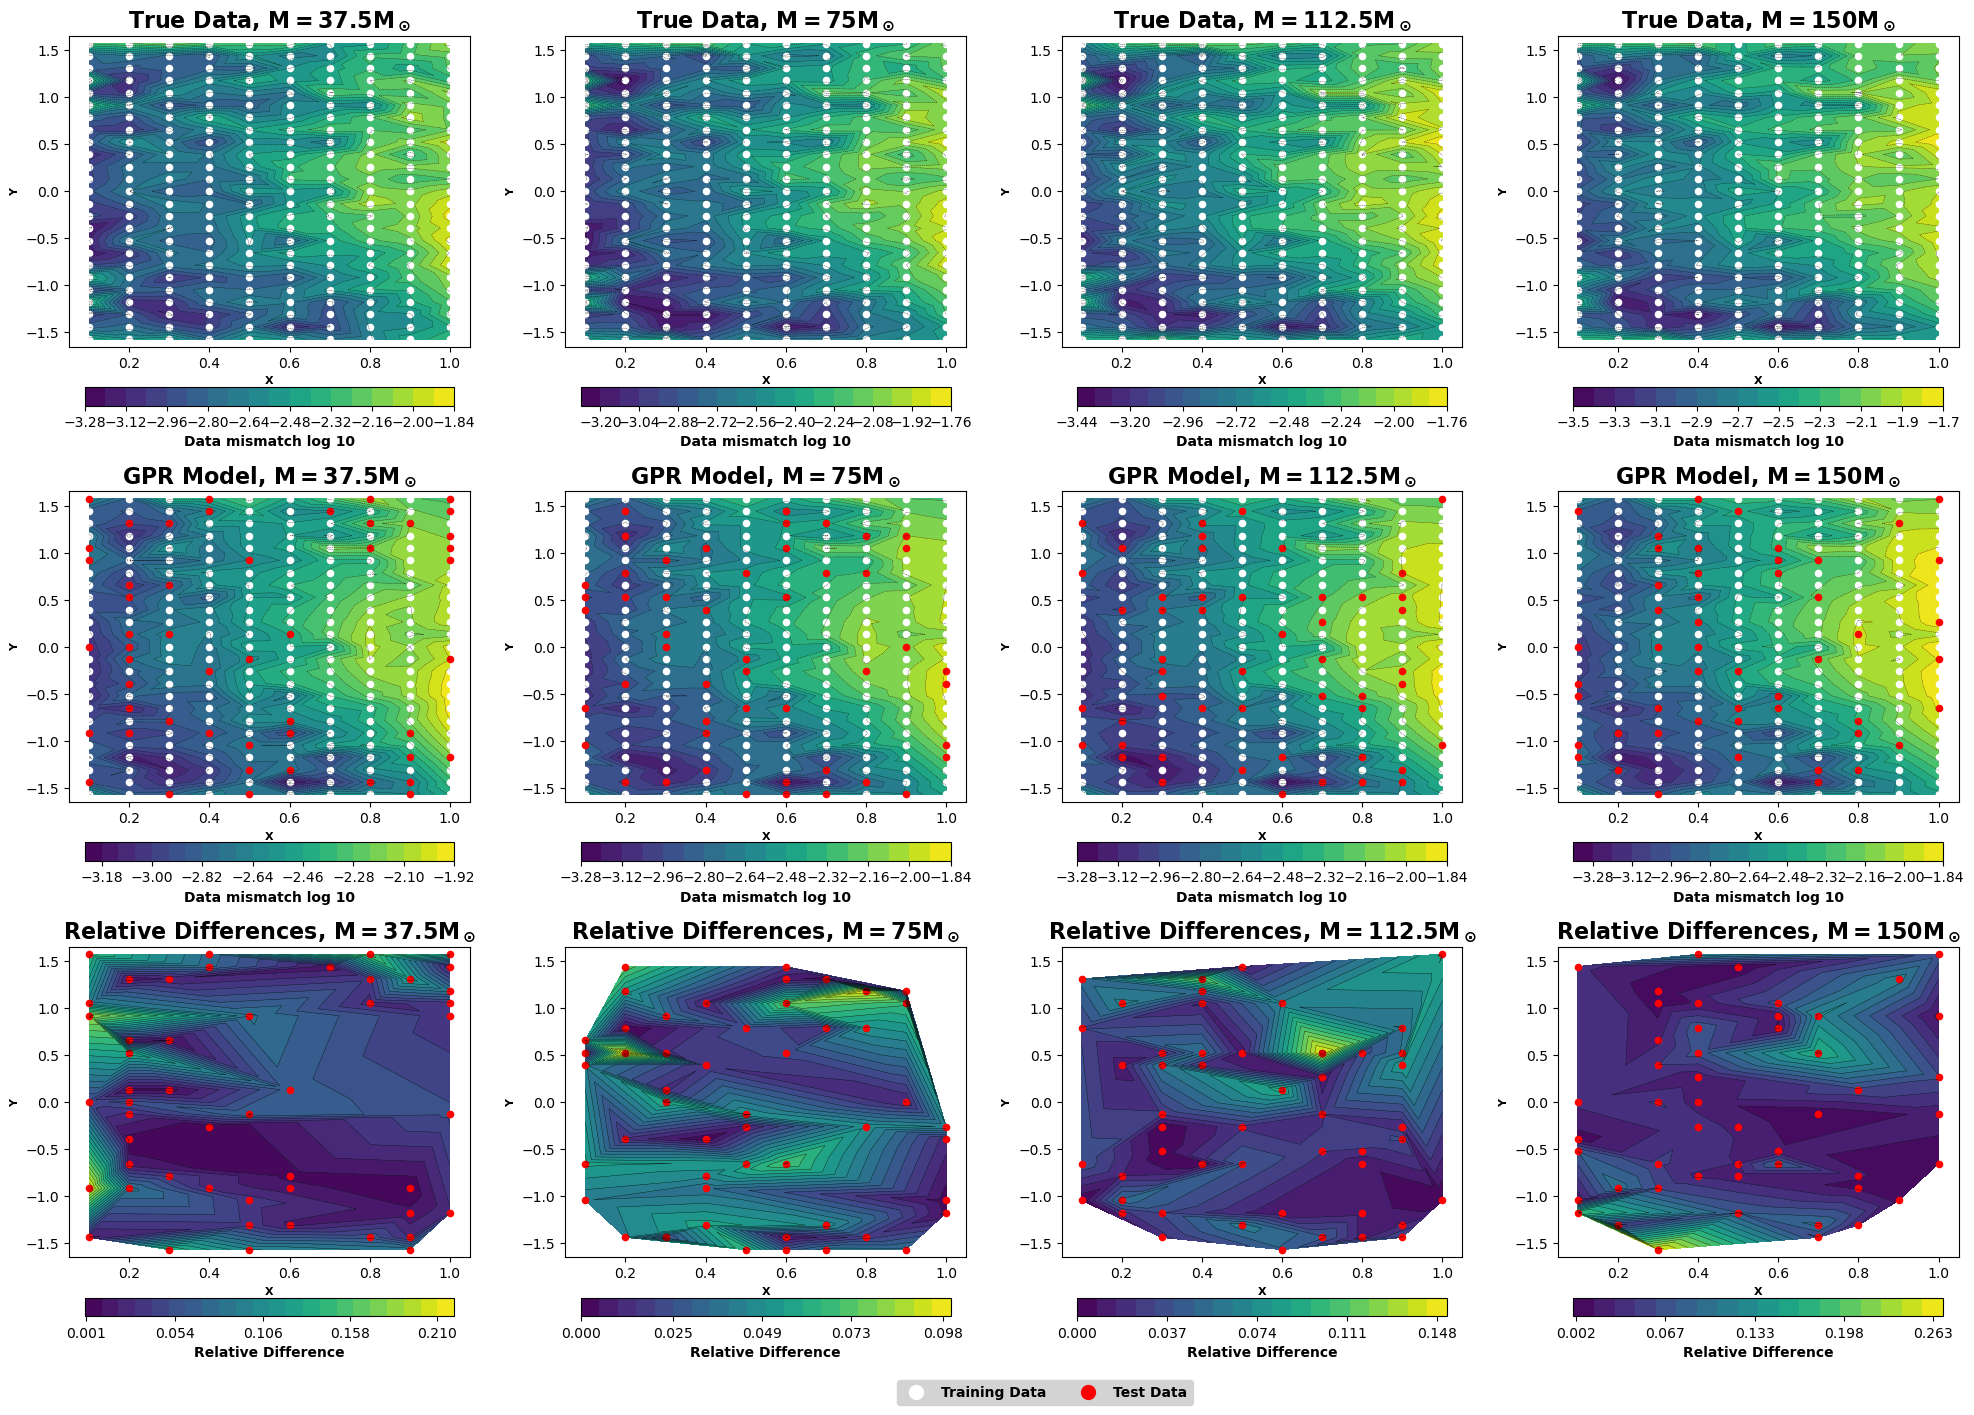

In [93]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Data
datasets = [
    (xm1, ym1, dm1, Dfit1, X1_train, X1_test, x_coords1, y_coords1, relative_difference1, r'$\mathbf{M = 37.5M_\odot}$'),
    (xm2, ym2, dm2, Dfit2, X2_train, X2_test, x_coords2, y_coords2, relative_difference2, r'$\mathbf{M = 75M_\odot}$'),
    (xm3, ym3, dm3, Dfit3, X3_train, X3_test, x_coords3, y_coords3, relative_difference3, r'$\mathbf{M = 112.5M_\odot}$'),
    (xm4, ym4, dm4, Dfit4, X4_train, X4_test, x_coords4, y_coords4, relative_difference4, r'$\mathbf{M = 150M_\odot}$'),
]


viridis_highcontrast = LinearSegmentedColormap.from_list("viridis_highcontrast", plt.cm.viridis(np.linspace(0, 1, 100)))



for col, (xm, ym, dm, Dfit, X_train, X_test, x_coords, y_coords, rel_diff, title) in enumerate(datasets):
    # Plot True Data
    contour1 = axes[0, col].tricontourf(xm, ym, dm, levels=20, cmap=viridis_highcontrast)
    axes[0, col].tricontour(xm, ym, dm, levels=20, colors='black', linewidths=0.25)
    axes[0, col].scatter(xm, ym, s=20,c='white')
    axes[0, col].set_xlim((0.05, 1.05))
    axes[0, col].set_ylim((-1.65, 1.65))
    axes[0, col].set_title(f'True Data, {title}', size=16, weight='bold')
    axes[0, col].set_xlabel('X', size=8, weight='bold')
    axes[0, col].set_ylabel('Y', size=8, weight='bold')
    cbar1 = fig.colorbar(contour1, ax=axes[0, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar1.set_label("Data mismatch log 10", size=10, weight='bold')
    #cbar1.set_ticks(np.around(np.linspace(dm.min(), dm.max(), 5), 1))  

    # Plot GPR Model
    contour2 = axes[1, col].tricontourf(xm, ym, Dfit, levels=20, cmap=viridis_highcontrast)
    axes[1, col].tricontour(xm, ym, Dfit, levels=20, colors='black', linewidths=0.25)
    axes[1, col].scatter(X_train[:, 0], X_train[:, 1], s=20,c='white', label='Train')
    axes[1, col].scatter(X_test[:, 0], X_test[:, 1], s=20,c='red', label='Test')
    axes[1, col].set_xlim((0.05, 1.05))
    axes[1, col].set_ylim((-1.65, 1.65))
    axes[1, col].set_title(f'GPR Model, {title}', size=16, weight='bold')
    axes[1, col].set_xlabel('X', size=8, weight='bold')
    axes[1, col].set_ylabel('Y', size=8, weight='bold')
    cbar2 = fig.colorbar(contour2, ax=axes[1, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar2.set_label("Data mismatch log 10", size=10, weight='bold')
    #cbar2.set_ticks(np.around(np.linspace(Dfit.min(), Dfit.max(), 5), 1)) 

    # Plot Relative Differences
    contour3 = axes[2, col].tricontourf(x_coords, y_coords, rel_diff, levels=20, cmap=viridis_highcontrast)
    axes[2, col].tricontour(x_coords, y_coords, rel_diff, levels=20, colors='black', linewidths=0.25)
    axes[2, col].scatter(x_coords, y_coords, s=20,c='red')
    axes[2, col].set_xlim((0.05, 1.05))
    axes[2, col].set_ylim((-1.65, 1.65))
    axes[2, col].set_title(f'Relative Differences, {title}', size=16, weight='bold')
    axes[2, col].set_xlabel('X', size=8, weight='bold')
    axes[2, col].set_ylabel('Y', size=8, weight='bold')
    cbar3 = fig.colorbar(contour3, ax=axes[2, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar3.set_label("Relative Difference", size=10, weight='bold')
    cbar3.set_ticks(np.around(np.linspace(rel_diff.min(), rel_diff.max(), 5), 3))  


train_marker = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=10, label='Training Data')
test_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Test Data')


fig.legend(
    handles=[train_marker, test_marker],
    loc='lower center', 
    bbox_to_anchor=(0.525, -0.025),  
    ncol=2,
    markerscale=1,
    fontsize=28,
    frameon=True,  # Turn on the legend frame
    prop={'weight': 'bold'}
)

# Customize the legend background color
legend = fig.legends[0]  # Access the legend object
legend.get_frame().set_facecolor('lightgrey')  # Set the background color to grey
legend.get_frame().set_edgecolor('lightgrey')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)


plt.tight_layout(rect=[0, 0, 1, 0.92]) 
#plt.savefig("4DGPRnoerrorbars", dpi=300, bbox_inches='tight')
#plt.savefig("4DGPRwerrorbars", dpi=300, bbox_inches='tight')
plt.show()

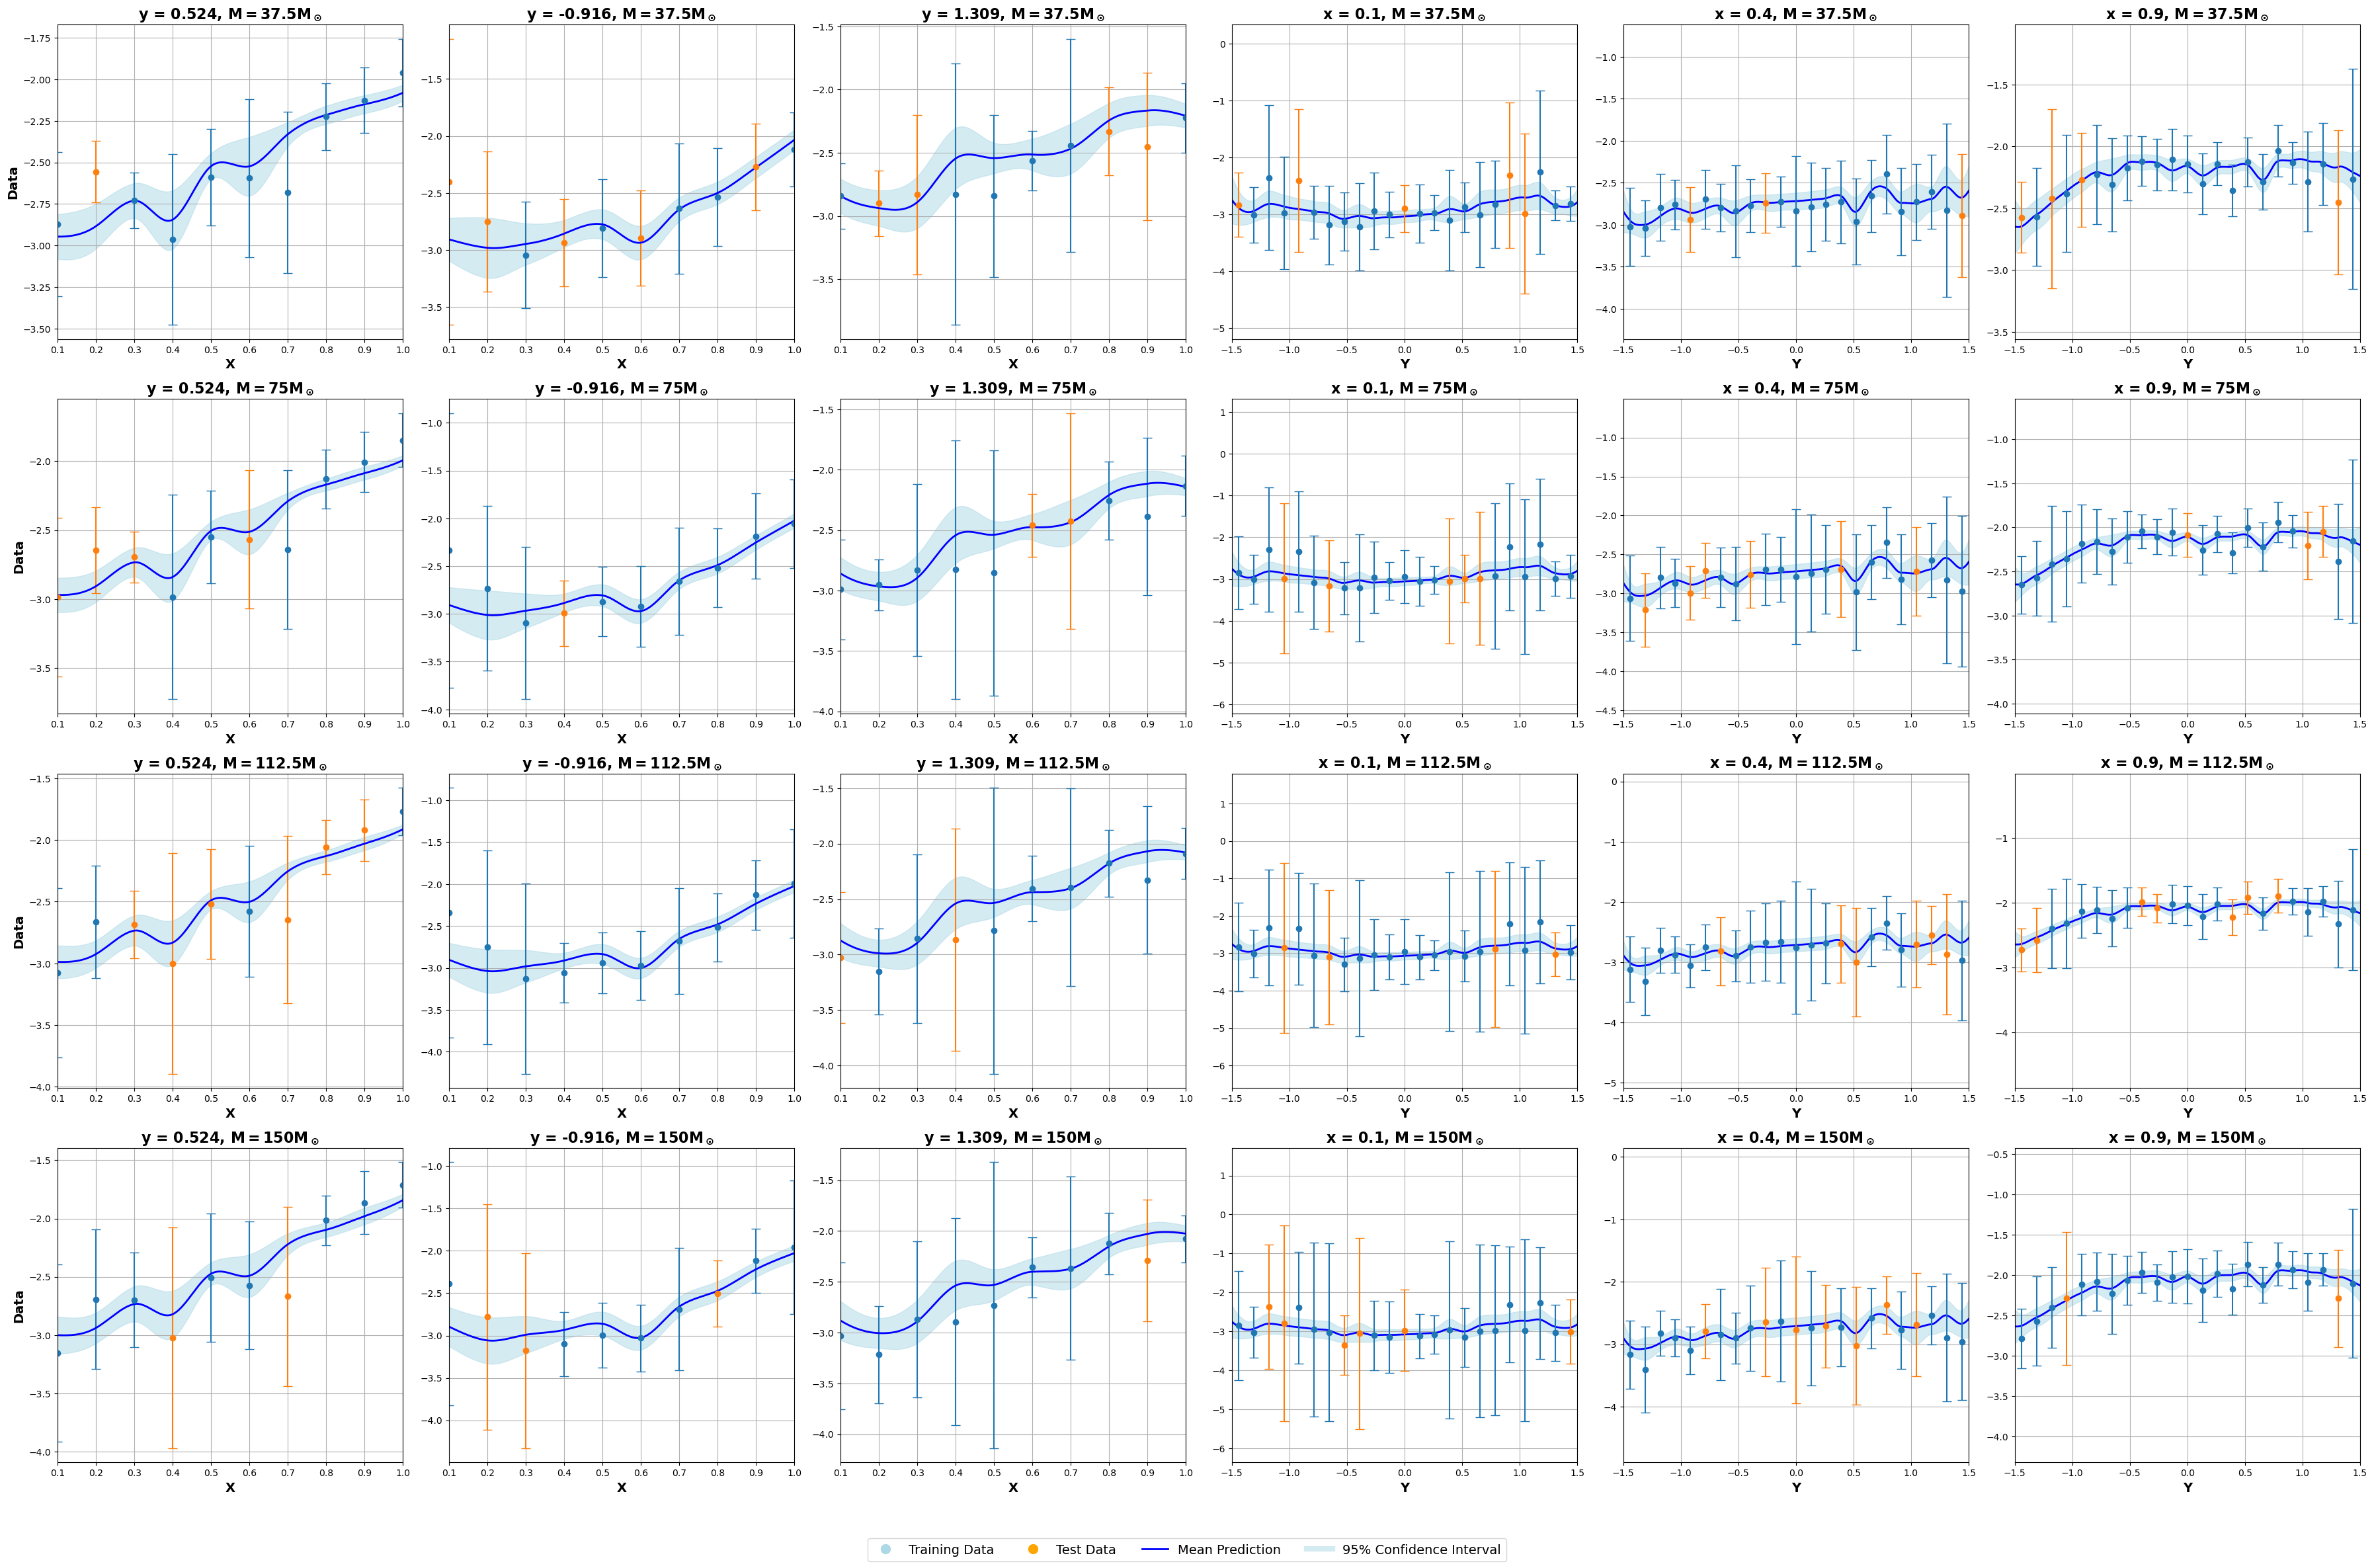

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import lines as mlines

# Slicing parameters:
# Horizontal slices: fixed y-values
ypoints = [0.5235987755982988, -0.9162978572970231, 1.3089969389957472]
# Vertical slices: fixed x-values
xpoints2 = [0.1, 0.4, 0.9]
# Fine grids for interpolation along x and y:
xpoints = np.linspace(0, 1, 1000)
ypoints2 = np.linspace(-1.5707963267948966, 1.5707963267948966, 1000)


# Define the data for each mass in a list of dictionaries.
# Make sure the variables (e.g. xm1, ym1, Dfit1, Dstd1, X1_train, etc.) are already defined.
masses = [
    {
        'mass_label': r'$\mathbf{M = 37.5M_\odot}$',
        'xm': xm1, 'ym': ym1,
        'Dfit': Dfit1, 'Dstd': Dstd1,
        'xtrain': X1_train[:, 0], 'ytrain': X1_train[:, 1],
        'xtest': X1_test[:, 0], 'ytest': X1_test[:, 1],
        'D_train': D1_train, 'D_test': D1_test,
        'E_train': E1_train, 'E_test': E1_test
    },
    {
        'mass_label': r'$\mathbf{M = 75M_\odot}$',
        'xm': xm2, 'ym': ym2,
        'Dfit': Dfit2, 'Dstd': Dstd2,
        'xtrain': X2_train[:, 0], 'ytrain': X2_train[:, 1],
        'xtest': X2_test[:, 0], 'ytest': X2_test[:, 1],
        'D_train': D2_train, 'D_test': D2_test,
        'E_train': E2_train, 'E_test': E2_test
    },
    {
        'mass_label': r'$\mathbf{M = 112.5M_\odot}$',
        'xm': xm3, 'ym': ym3,
        'Dfit': Dfit3, 'Dstd': Dstd3,
        'xtrain': X3_train[:, 0], 'ytrain': X3_train[:, 1],
        'xtest': X3_test[:, 0], 'ytest': X3_test[:, 1],
        'D_train': D3_train, 'D_test': D3_test,
        'E_train': E3_train, 'E_test': E3_test
    },
    {
        'mass_label': r'$\mathbf{M = 150M_\odot}$',
        'xm': xm4, 'ym': ym4,
        'Dfit': Dfit4, 'Dstd': Dstd4,
        'xtrain': X4_train[:, 0], 'ytrain': X4_train[:, 1],
        'xtest': X4_test[:, 0], 'ytest': X4_test[:, 1],
        'D_train': D4_train, 'D_test': D4_test,
        'E_train': E4_train, 'E_test': E4_test
    },
]

# Create a figure with 4 rows (one per mass) and 6 columns (3 horizontal slices, 3 vertical slices)
fig, axes = plt.subplots(4, 6, figsize=(36, 24))

# Loop over masses (each row)
for row, mass in enumerate(masses):
    mass_label = mass['mass_label']
    xm, ym = mass['xm'], mass['ym']
    Dfit, Dstd = mass['Dfit'], mass['Dstd']
    xtrain, ytrain = mass['xtrain'], mass['ytrain']
    xtest, ytest = mass['xtest'], mass['ytest']
    D_train, D_test = mass['D_train'], mass['D_test']
    E_train, E_test = mass['E_train'], mass['E_test']
    
    # --- Horizontal slices (fixed y) in columns 0-2 ---
    for col in range(3):
        ax = axes[row, col]
        y_val = ypoints[col]
        
        # Interpolate predicted mean and std along x at the fixed y value:
        mean_line = griddata((xm, ym), Dfit, (xpoints, y_val), method="cubic")
        std_line = griddata((xm, ym), Dstd, (xpoints, y_val), method="cubic")
        
        # Find training and test points near y = y_val
        tol = 1e-3
        idx_train = np.isclose(ytrain, y_val, atol=tol)
        idx_test  = np.isclose(ytest, y_val, atol=tol)
        
        if includeerror == 1:
            # Plot only error bars (without markers; fmt='none')
            ax.errorbar(
                xtrain[idx_train].ravel(),
                D_train[idx_train].ravel(),
                yerr=E_train[idx_train].ravel(),
                fmt='o',
                capsize=5,
                label='Training Data'
            )
            ax.errorbar(
                xtest[idx_test].ravel(),
                D_test[idx_test].ravel(),
                yerr=E_test[idx_test].ravel(),
                fmt='o',
                capsize=5,
                label='Test Data'
            )
        else:
            ax.scatter(xtrain[idx_train], D_train[idx_train], s=100, color='black', label='Training Data')
            ax.scatter(xtest[idx_test], D_test[idx_test], s=200, color='red', label='Test Data')
        
        # Plot the interpolated mean prediction and a 95% confidence interval
        ax.plot(xpoints, mean_line, color='blue', linewidth=2, label='Mean Prediction')
        ax.fill_between(
            xpoints,
            mean_line - 2 * std_line,
            mean_line + 2 * std_line,
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        ax.set_xlim((0.1, 1))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(f"y = {round(y_val, 3)}, {mass_label}", fontsize=16, weight='bold')
        ax.grid(True)
    
    # --- Vertical slices (fixed x) in columns 3-5 ---
    for j, col in enumerate(range(3, 6)):
        ax = axes[row, col]
        x_val = xpoints2[j]
        
        # Interpolate the predicted mean and std along y at fixed x:
        mean_line = griddata((xm, ym), Dfit, (x_val, ypoints2), method="cubic")
        std_line  = griddata((xm, ym), Dstd, (x_val, ypoints2), method="cubic")
        
        tol = 1e-3
        idx_train = np.isclose(xtrain, x_val, atol=tol)
        idx_test  = np.isclose(xtest,  x_val, atol=tol)
        
        ax.plot(ypoints2, mean_line, color='blue', linewidth=2, label='Mean Prediction')
        if includeerror == 1:
            ax.errorbar(
                ytrain[idx_train].ravel(),
                D_train[idx_train].ravel(),
                yerr=E_train[idx_train].ravel(),
                fmt='o',
                capsize=5,
                label='Training Data'
            )
            ax.errorbar(
                ytest[idx_test].ravel(),
                D_test[idx_test].ravel(),
                yerr=E_test[idx_test].ravel(),
                fmt='o',
                capsize=5,
                label='Test Data'
            )
        else:
            ax.scatter(ytrain[idx_train], D_train[idx_train], s=100, color='black', label='Training Data')
            ax.scatter(ytest[idx_test], D_test[idx_test], s=200, color='red', label='Test Data')
        
        ax.fill_between(
            ypoints2,
            mean_line - 2 * std_line,
            mean_line + 2 * std_line,
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        ax.set_xlim((-1.5, 1.5))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(f"x = {round(x_val, 3)}, {mass_label}", fontsize=16, weight='bold')
        ax.grid(True)

# Set a common Y label for the leftmost column of subplots
for ax in axes[:, 0]:
    ax.set_ylabel('Data', fontsize=14, weight='bold')

# Create custom legend handles to be shown in a global legend
train_marker = mlines.Line2D([], [], color='lightblue', marker='o', linestyle='None', markersize=10, label='Training Data')
test_marker  = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=10, label='Test Data')
mean_line_handle = mlines.Line2D([], [], color='blue', lw=2, label='Mean Prediction')
ci_handle = mlines.Line2D([], [], color='lightblue', lw=6, alpha=0.5, label='95% Confidence Interval')

fig.legend(
    handles=[train_marker, test_marker, mean_line_handle, ci_handle],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=4,
    markerscale=1,
    fontsize=14,
    frameon=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.savefig("4Dcrosscutnoerrorbars", dpi=300, bbox_inches='tight')
#plt.savefig("4Dcrosscutwerrorbars", dpi=300, bbox_inches='tight')
plt.show()



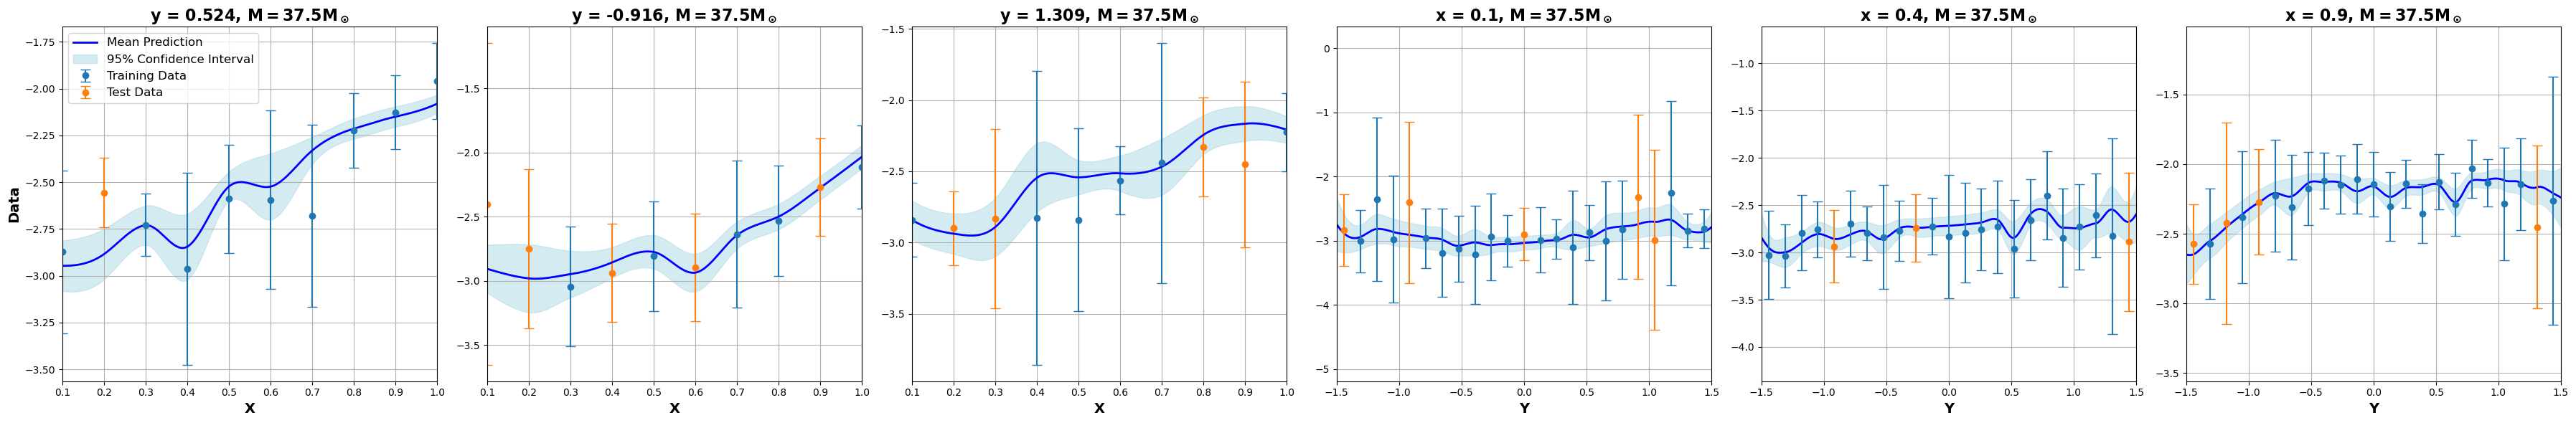

In [33]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]


fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
j = 0

for i, ax in enumerate(axes):
    if (i<=2):
        ypoint = ypoints[i]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoints, ypoint), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoints, ypoint), method="cubic")
        indices1 = np.isclose(y1train,ypoints[i])
        indices2 = np.isclose(y1test,ypoints[i])
        
        if includeerror ==1 :
            ax.errorbar(x1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(), fmt='o', capsize=5,label = 'Training Data')
            ax.errorbar(x1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
        else:
            ax.scatter(x1train[indices1],D1_train[indices1],s=100,color='black',label = 'Training Data')
            ax.scatter(x1test[indices2],D1_test[indices2],s=200,color='red',label = 'Test Data')
        ax.plot(xpoints, zgridlinear_mean,label='Mean Prediction', color='blue', linewidth=2)
        ax.fill_between(
            xpoints,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((0.1, 1))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
    else:
        xpoint = xpoints2[j]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoint, ypoints2), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoint, ypoints2), method="cubic")

        indices1 = np.isclose(x1train,xpoint)
        indices2 = np.isclose(x1test,xpoint)
        ax.plot(ypoints2, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=2)
        if includeerror == 1:
            ax.errorbar(y1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(),fmt='o', capsize=5,label = 'Training Data')
            ax.errorbar(y1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
        else:
            ax.scatter(y1train[indices1],D1_train[indices1],s=100,color='black',label = 'Training Data')
            ax.scatter(y1test[indices2],D1_test[indices2],s=200,color='red',label = 'Test Data')    
        ax.fill_between(
            ypoints2,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((-1.5, 1.5))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
        j+=1
        
axes[0].set_ylabel('Data', fontsize=14, weight='bold')

axes[0].legend(fontsize=12,loc='upper left',frameon=True)
legend.get_frame().set_facecolor('white')  # Set the background color to grey
legend.get_frame().set_edgecolor('white')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)

#plt.savefig("", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()